# Clustering data using K-MEANS and K-MEDOIDES and K-MM

COMPLETE CLUSTERING ANALYSIS FOR RETAIL CUSTOMER DATASET

Description of the dataset:
This dataset contains detailed information on 10000 retail customers with 20+ variables covering:
- Demographics (age, gender, income)
- Shopping behaviors (frequency, value, preferred categories)
- Digital engagement (time on site, email open rates)
- Customer lifecycle (tenure, last activity)
- Price sensitivity (promotional purchases)
- Customer service (support contacts)
- Loyalty and customer value (cart abandonment, lifetime value)
- Geographic and temporal characteristics

## Imports

Import the python modules that we need in the rest of the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings('ignore')

## Load data

Use the cell below to load the retail_customer_dataset.csv file into a pandas DataFrame.

In [2]:
df = pd.read_csv('data/retail_customer_dataset.csv')
# print(df.head())
# print(df.describe().T)
# print(df.isnull().sum())


## Preliminary Analysis

In this section, we will perform an initial analysis of the dataset to understand its structure, identify missing values, and explore key statistics. This will help us prepare the data for clustering and ensure its quality.


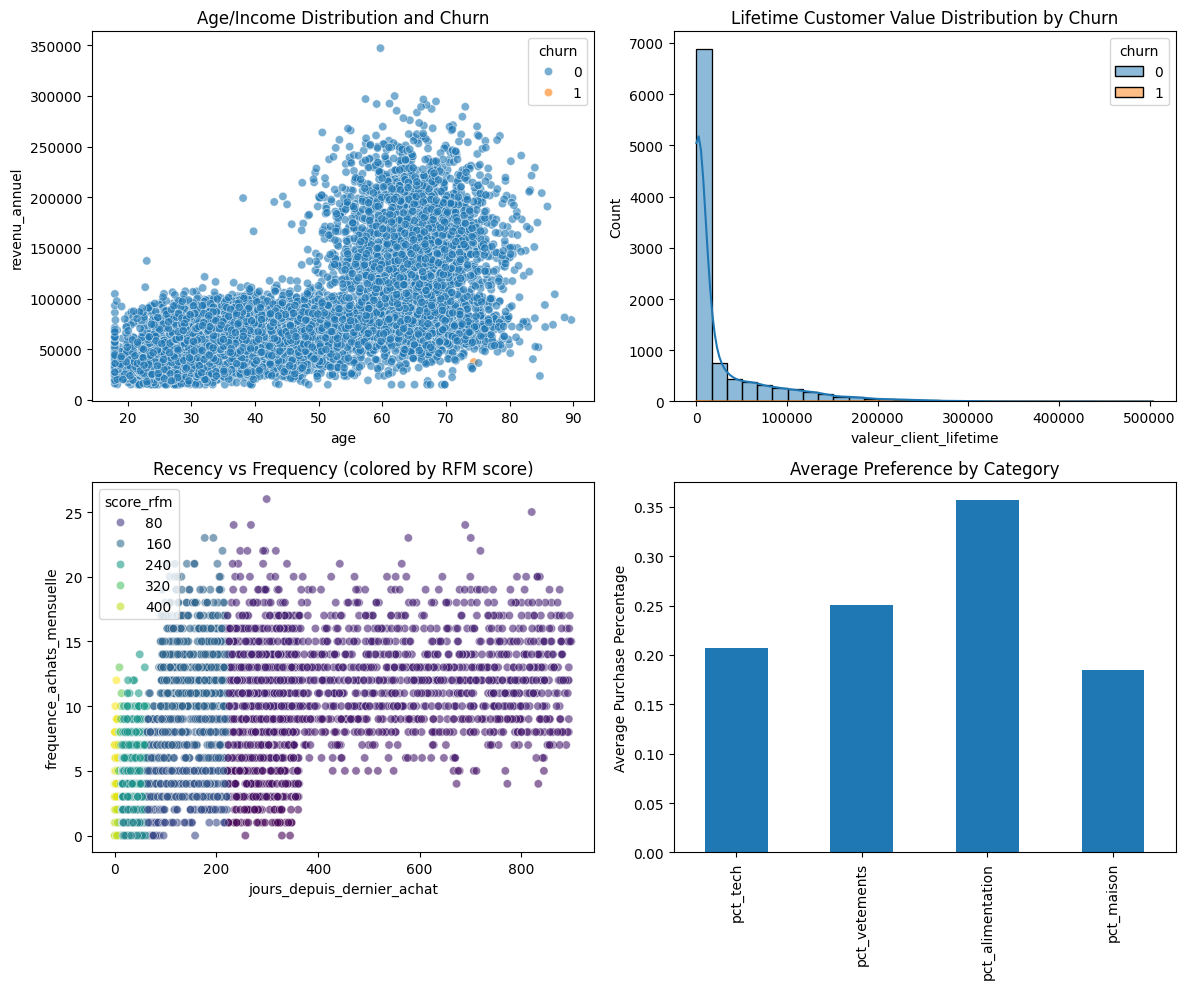

In [3]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='age', y='revenu_annuel', hue='churn', data=df, alpha=0.6)
plt.title('Age/Income Distribution and Churn')

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='valeur_client_lifetime', hue='churn', kde=True, bins=30)
plt.title('Lifetime Customer Value Distribution by Churn')

plt.subplot(2, 2, 3)
sns.scatterplot(x='jours_depuis_dernier_achat', y='frequence_achats_mensuelle', 
                hue='score_rfm', data=df, palette='viridis', alpha=0.6)
plt.title('Recency vs Frequency (colored by RFM score)')

plt.subplot(2, 2, 4)
cat_avg = df[['pct_tech', 'pct_vetements', 'pct_alimentation', 'pct_maison']].mean()
cat_avg.plot(kind='bar')
plt.title('Average Preference by Category')
plt.ylabel('Average Purchase Percentage')

plt.tight_layout()
plt.show()

In [4]:
features = ['age', 'revenu_annuel', 'montant_moyen_achat', 'frequence_achats_mensuelle',
            'temps_site_minutes', 'taux_ouverture_emails', 'pct_tech', 'pct_vetements',
            'pct_alimentation', 'pct_maison', 'taux_retour', 'anciennete_jours',
            'nb_contacts_support', 'jours_depuis_dernier_achat', 'pct_achats_promotion',
            'valeur_client_lifetime', 'taux_abandon_panier', 'heures_achat', 'distance_magasin_km']

# Variables catégorielles à encoder
cat_features = ['canal_acquisition', 'appareil_prefere', 'region', 'genre']
# Extraire X pour le clustering
X_numeric = df[features].copy()
X_cat = df[cat_features].copy()


In [5]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features),
        ('cat', categorical_transformer, cat_features)
    ])
X_processed = preprocessor.fit_transform(df[features + cat_features])
print(f"\nDimensions of the data after preprocessing: {X_processed.shape}")



Dimensions of the data after preprocessing: (10000, 32)


## Determine the Number of Clusters


*Note: This section aims to identify the optimal number of clusters for our dataset, which is a crucial step in clustering analysis.*


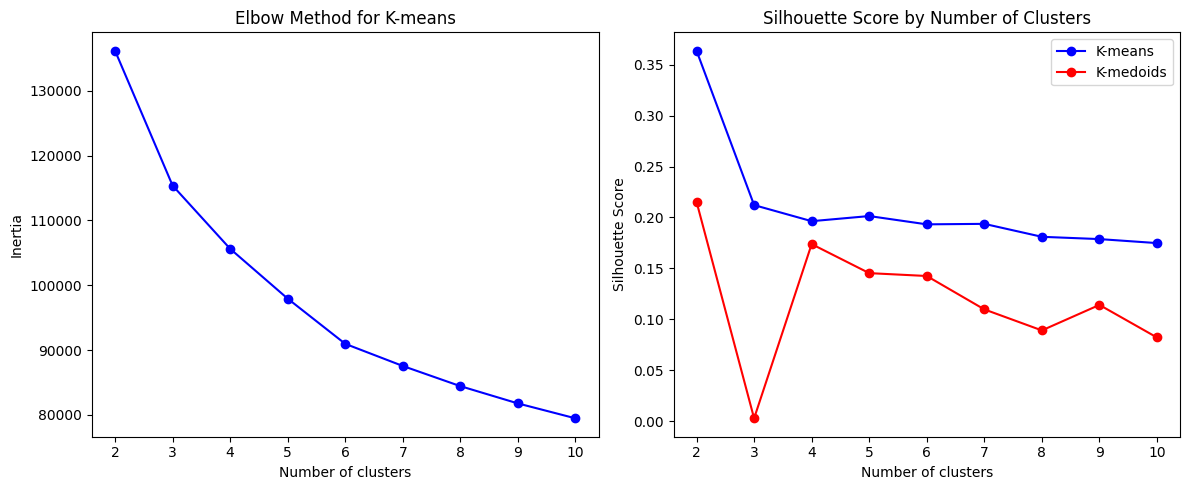

In [6]:
range_n_clusters = range(2, 11)
silhouette_scores_kmeans = []
silhouette_scores_kmedoids = []
inertia = []

for n_clusters in range_n_clusters:
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    labels_kmeans = kmeans.labels_
    silhouette_scores_kmeans.append(silhouette_score(X_processed, labels_kmeans))
    inertia.append(kmeans.inertia_)
    
    # K-medoids 
    if X_processed.shape[0] > 1000:
        sample_idx = np.random.choice(X_processed.shape[0], 1000, replace=False)
        X_sample = X_processed[sample_idx]
        kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean')
        labels_kmedoids = kmedoids.fit_predict(X_sample)
        silhouette_scores_kmedoids.append(silhouette_score(X_sample, labels_kmedoids))
    else:
        kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean')
        labels_kmedoids = kmedoids.fit_predict(X_processed)
        silhouette_scores_kmedoids.append(silhouette_score(X_processed, labels_kmedoids))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, 'o-', color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-means')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores_kmeans, 'o-', color='blue', label='K-means')
plt.plot(range_n_clusters, silhouette_scores_kmedoids, 'o-', color='red', label='K-medoids')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
optimal_n_clusters = 6

## Part 1 : Clustering with K-means

In [8]:
start_time_kmeans = time.time()
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_processed)
end_time_kmeans = time.time()
execution_time_kmeans = end_time_kmeans - start_time_kmeans

silhouette_kmeans = silhouette_score(X_processed, kmeans_labels)
db_score_kmeans = davies_bouldin_score(X_processed, kmeans_labels)
ch_score_kmeans = calinski_harabasz_score(X_processed, kmeans_labels)

print(f"Execution time of K-means: {execution_time_kmeans:.4f} seconds")
print(f"Silhouette score: {silhouette_kmeans:.4f}")
print(f"Davies-Bouldin score: {db_score_kmeans:.4f} (lower = better)")
print(f"Calinski-Harabasz score: {ch_score_kmeans:.4f} (higher = better)")

Execution time of K-means: 0.3276 seconds
Silhouette score: 0.1932
Davies-Bouldin score: 1.8067 (lower = better)
Calinski-Harabasz score: 2655.0012 (higher = better)


## Analyze the clusters


Average profile of K-means clusters:
                      age  revenu_annuel  montant_moyen_achat  \
cluster_kmeans                                                  
0               65.062256  150123.315678           296.331159   
1               37.191802   64116.667195            83.137058   
2               34.710562   50088.960366            30.052138   
3               65.085703  150296.637186           292.444198   
4               25.731780   35664.202407            29.909517   
5               49.598009   70089.106489           100.309355   

                frequence_achats_mensuelle  temps_site_minutes  \
cluster_kmeans                                                   
0                                12.149558           35.291876   
1                                 3.469814           13.157376   
2                                 1.641901            9.453204   
3                                11.700661           37.538790   
4                                 1.027184   

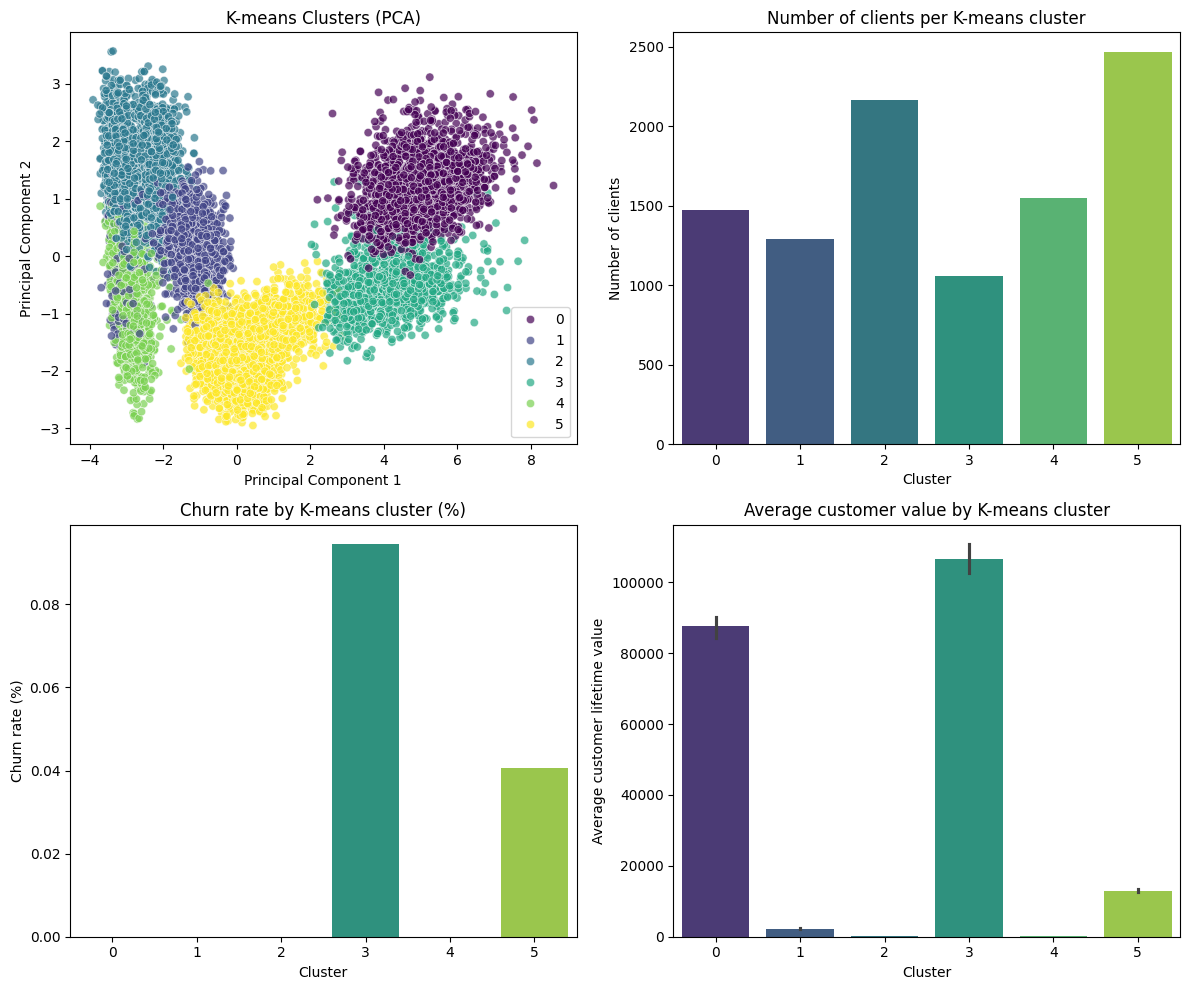

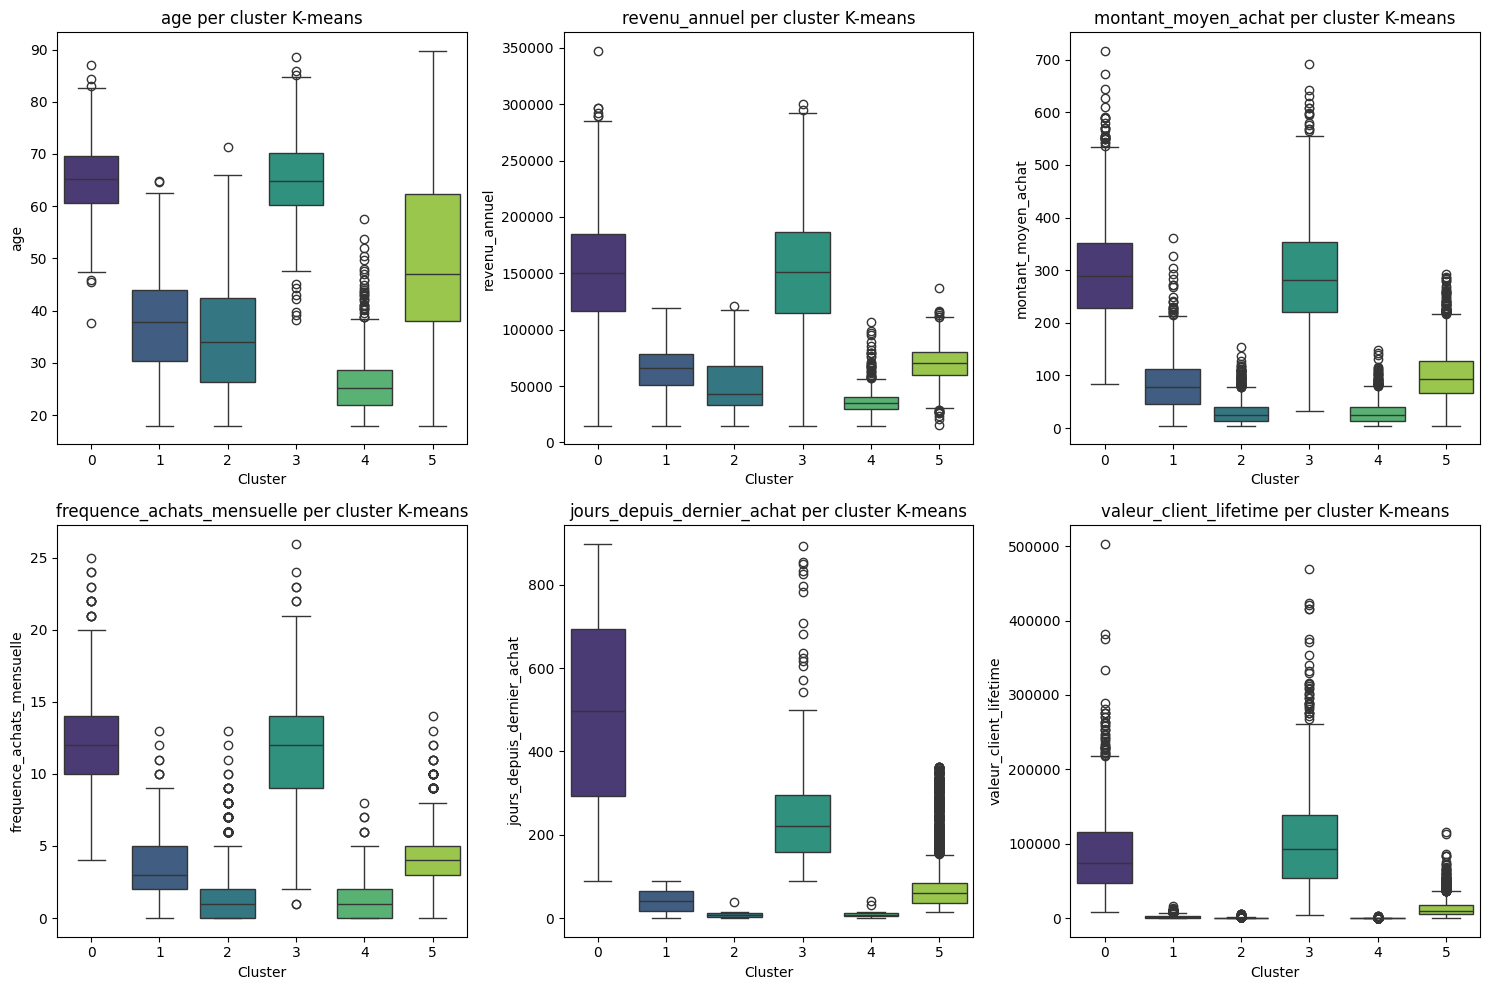

In [9]:
df['cluster_kmeans'] = kmeans_labels
kmeans_cluster_stats = df.groupby('cluster_kmeans')[features].mean()
print("\nAverage profile of K-means clusters:")
print(kmeans_cluster_stats)

# Distribution des clients par cluster
kmeans_cluster_counts = df['cluster_kmeans'].value_counts().sort_index()
print("\nDistribution of clients by K-means cluster:")
print(kmeans_cluster_counts)

# Taux de churn par cluster
kmeans_churn_by_cluster = df.groupby('cluster_kmeans')['churn'].mean() * 100
print("\nChurn rate by K-means cluster (%):")
print(kmeans_churn_by_cluster)

# Visualisation des clusters K-means avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(12, 10))

# Scatter plot des clusters
plt.subplot(2, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', alpha=0.7)
plt.title('K-means Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Distribution des clients par cluster
plt.subplot(2, 2, 2)
sns.countplot(x='cluster_kmeans', data=df, palette='viridis')
plt.title('Number of clients per K-means cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of clients')

# Taux de churn par cluster
plt.subplot(2, 2, 3)
sns.barplot(x=kmeans_churn_by_cluster.index, y=kmeans_churn_by_cluster.values, palette='viridis')
plt.title('Churn rate by K-means cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Churn rate (%)')

# Valeur client moyenne par cluster
plt.subplot(2, 2, 4)
sns.barplot(x='cluster_kmeans', y='valeur_client_lifetime', data=df, palette='viridis')
plt.title('Average customer value by K-means cluster')
plt.xlabel('Cluster')
plt.ylabel('Average customer lifetime value')

plt.tight_layout()
plt.show()

# Analyse des caractéristiques principales des clusters
plt.figure(figsize=(15, 10))
features_to_plot = ['age', 'revenu_annuel', 'montant_moyen_achat', 'frequence_achats_mensuelle', 
                    'jours_depuis_dernier_achat', 'valeur_client_lifetime']

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='cluster_kmeans', y=feature, data=df, palette='viridis')
    plt.title(f'{feature} per cluster K-means')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## PARTIE 2: CLUSTERING WITH K-MEDOIDS

In [10]:
X_kmedoids = X_processed
df_kmedoids = df.copy()
start_time_kmedoids = time.time()
kmedoids = KMedoids(n_clusters=optimal_n_clusters, random_state=42, metric='euclidean', method='alternate')
kmedoids_labels = kmedoids.fit_predict(X_kmedoids)
end_time_kmedoids = time.time()
execution_time_kmedoids = end_time_kmedoids - start_time_kmedoids

silhouette_kmedoids = silhouette_score(X_kmedoids, kmedoids_labels)
db_score_kmedoids = davies_bouldin_score(X_kmedoids, kmedoids_labels)
ch_score_kmedoids = calinski_harabasz_score(X_kmedoids, kmedoids_labels)

print(f"Execution time of K-medoids: {execution_time_kmedoids:.4f} seconds")
print(f"Silhouette score: {silhouette_kmedoids:.4f}")
print(f"Davies-Bouldin score: {db_score_kmedoids:.4f} (lower = better)")
print(f"Calinski-Harabasz score: {ch_score_kmedoids:.4f} (higher = better)")

Execution time of K-medoids: 4.4735 seconds
Silhouette score: 0.1145
Davies-Bouldin score: 2.6324 (lower = better)
Calinski-Harabasz score: 2168.3836 (higher = better)



Average profile of K-medoides clusters:
                        age  revenu_annuel  montant_moyen_achat  \
cluster_kmedoids                                                  
0                 65.110148  152433.380654           299.318993   
1                 32.981638   47066.162269            29.856614   
2                 35.358829   56188.773426            56.348223   
3                 51.915986   70604.197592           103.717736   
4                 46.436053   75267.158100           110.799267   
5                 25.842711   36342.702367            29.627577   

                  frequence_achats_mensuelle  temps_site_minutes  \
cluster_kmedoids                                                   
0                                  12.147121           36.462060   
1                                   1.521559            8.642095   
2                                   2.558873           11.089957   
3                                   4.081998           20.950346   
4             

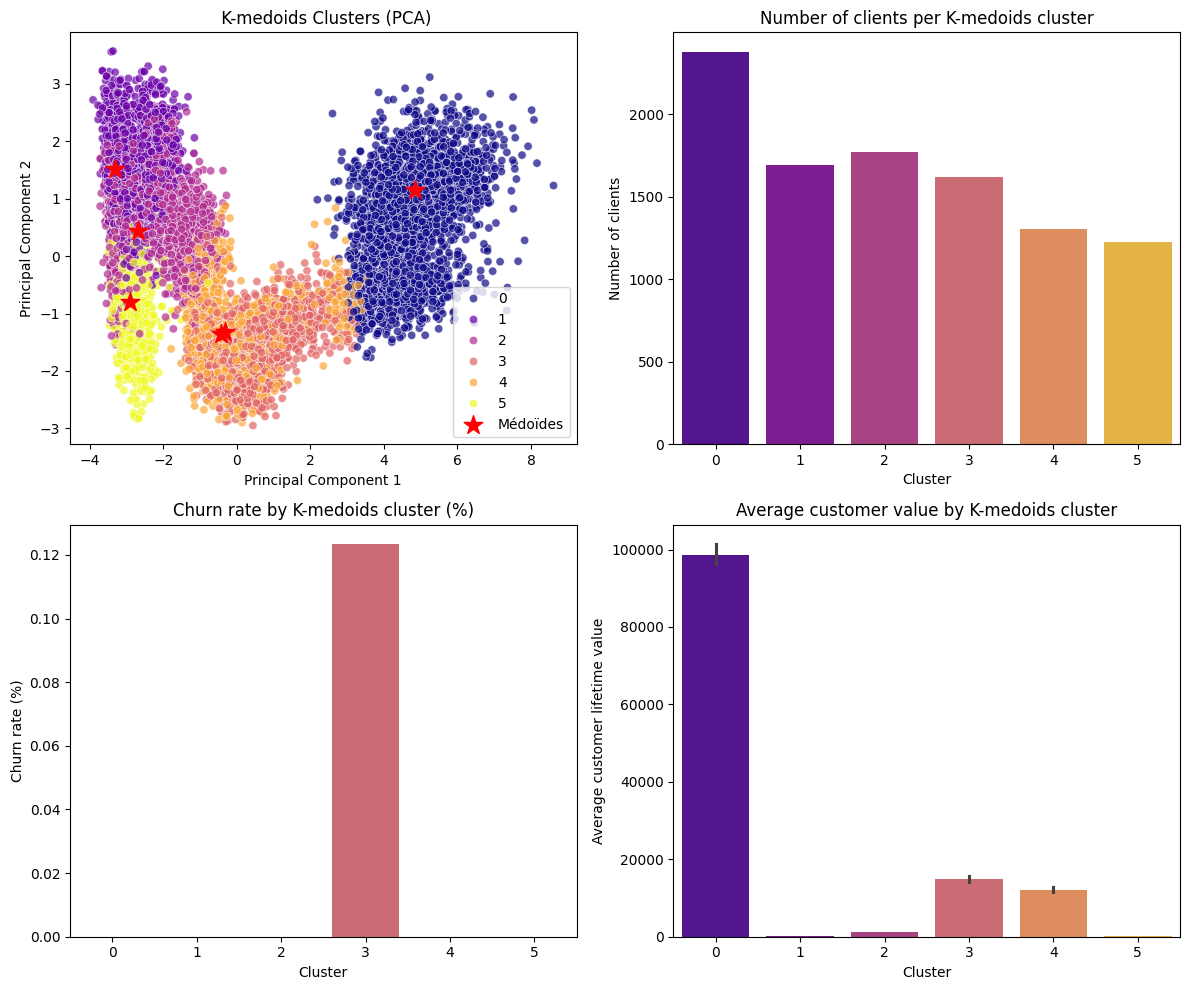

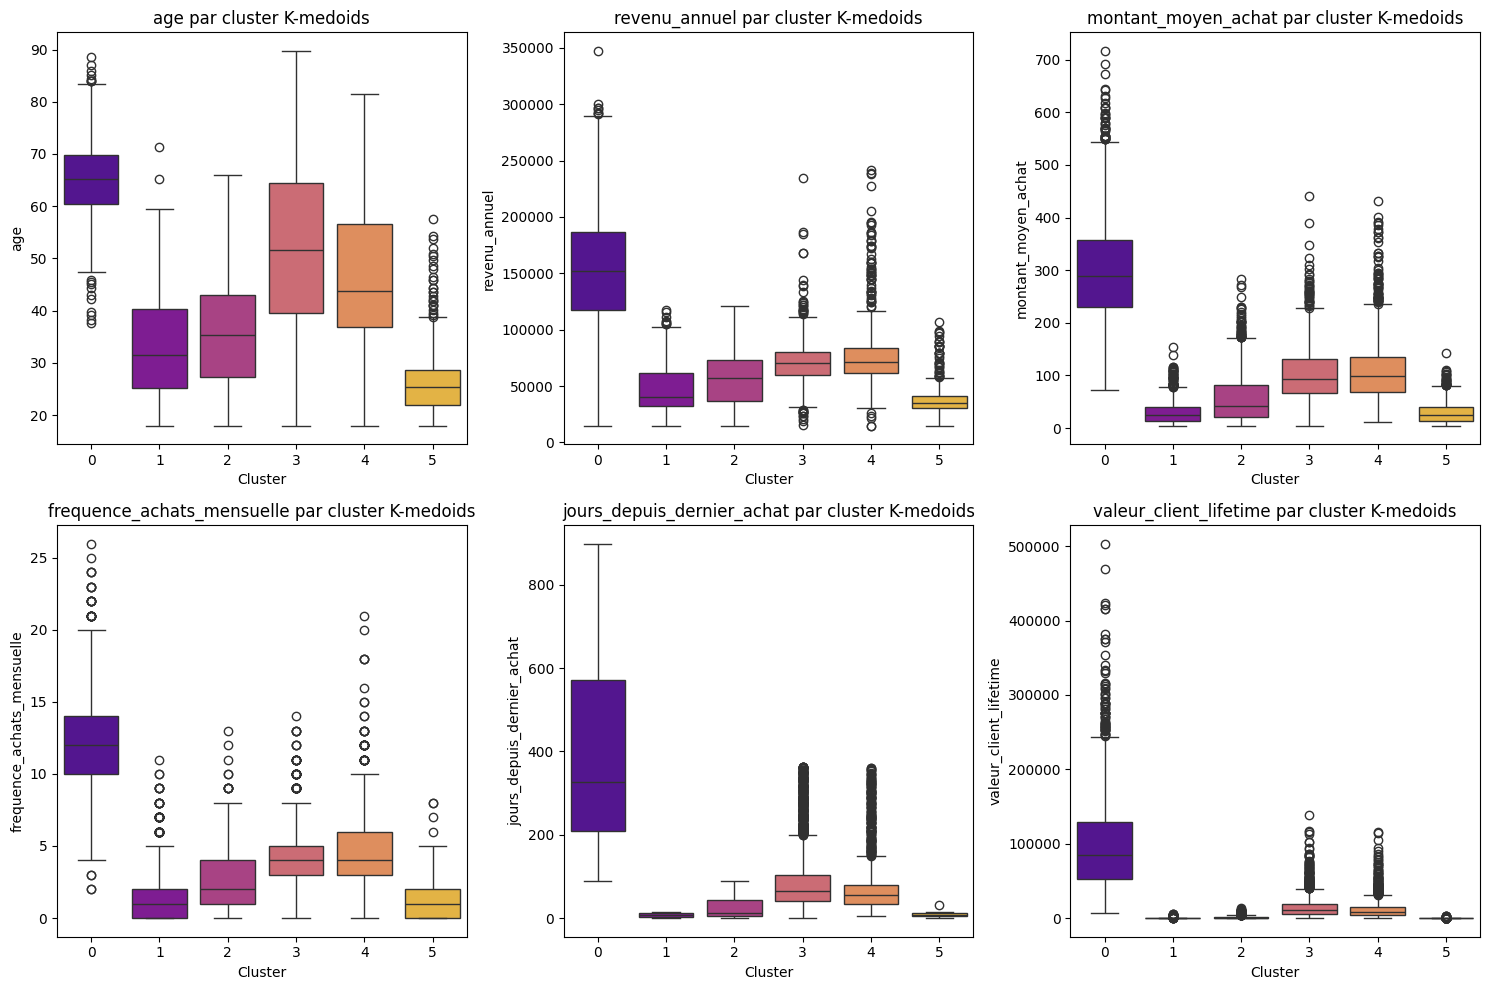

In [11]:
df_kmedoids['cluster_kmedoids'] = kmedoids_labels
kmedoids_cluster_stats = df_kmedoids.groupby('cluster_kmedoids')[features].mean()
print("\nAverage profile of K-medoides clusters:")
print(kmedoids_cluster_stats)

# Distribution des clients par cluster
kmedoids_cluster_counts = df_kmedoids['cluster_kmedoids'].value_counts().sort_index()
print("\nDistribution of clients by K-medoids cluster:")
print(kmedoids_cluster_counts)

# Taux de churn par cluster
kmedoids_churn_by_cluster = df_kmedoids.groupby('cluster_kmedoids')['churn'].mean() * 100
print("\nChurn rate by K-medoids cluster (%):")
print(kmedoids_churn_by_cluster)

# Visualisation des clusters K-medoids
if X_kmedoids.shape[0] > 1000:
    # Si on a sous-échantillonné, appliquer PCA sur le sous-échantillon
    X_pca_kmedoids = pca.transform(X_kmedoids)
else:
    # Sinon utiliser la même projection PCA que pour K-means
    X_pca_kmedoids = X_pca

plt.figure(figsize=(12, 10))

# Scatter plot des clusters
plt.subplot(2, 2, 1)
sns.scatterplot(x=X_pca_kmedoids[:, 0], y=X_pca_kmedoids[:, 1], hue=kmedoids_labels, palette='plasma', alpha=0.7)
plt.title(' K-medoids Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Afficher les médoïdes
medoid_indices = kmedoids.medoid_indices_
plt.scatter(X_pca_kmedoids[medoid_indices, 0], X_pca_kmedoids[medoid_indices, 1], 
            s=200, marker='*', c='red', label='Médoïdes')
plt.legend()

# Distribution des clients par cluster
plt.subplot(2, 2, 2)
sns.countplot(x='cluster_kmedoids', data=df_kmedoids, palette='plasma')
plt.title('Number of clients per K-medoids cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of clients')

# Taux de churn par cluster
plt.subplot(2, 2, 3)
sns.barplot(x=kmedoids_churn_by_cluster.index, y=kmedoids_churn_by_cluster.values, palette='plasma')
plt.title('Churn rate by K-medoids cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Churn rate (%)')

# Valeur client moyenne par cluster
plt.subplot(2, 2, 4)
sns.barplot(x='cluster_kmedoids', y='valeur_client_lifetime', data=df_kmedoids, palette='plasma')
plt.title('Average customer value by K-medoids cluster')
plt.xlabel('Cluster')
plt.ylabel('Average customer lifetime value')

plt.tight_layout()
plt.show()

# Analyse des caractéristiques principales des clusters
plt.figure(figsize=(15, 10))
features_to_plot = ['age', 'revenu_annuel', 'montant_moyen_achat', 'frequence_achats_mensuelle', 
                    'jours_depuis_dernier_achat', 'valeur_client_lifetime']

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='cluster_kmedoids', y=feature, data=df_kmedoids, palette='plasma')
    plt.title(f'{feature} par cluster K-medoids')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## PARTIE 3: CLUSTERING WITH K-MM

In [16]:
def centroid_medoids(
    X,
    n_clusters,
    r=10,
    candidate_fraction=0.1,
    max_iter=1000,
    tol=1e-4,
    random_state=None
):
    """
    Hybridation K-means / K-medoids ("Centroid-Medoids").

    1) on lance KMeans pour r itérations ;
    2) pour chaque cluster, on teste quelques medoids candidats :
       si l’un d’eux réduit la dispersion (somme des distances),
       on remplace le centroïde par ce medoid ;
    3) on relance KMeans (init aux nouveaux centres) jusqu’à convergence.

    Returns
    -------
    labels : array, shape (n_samples,)
        Étiquettes de cluster finales
    model : fitted KMeans
        Modèle KMeans “final” (dont on peut extraire cluster_centers_)
    """
    rng = np.random.RandomState(random_state)

    # 1) KMeans “rapide” pour r itérations
    km1 = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        max_iter=r,
        n_init=1,
        tol=tol,
        random_state=random_state
    )
    labels = km1.fit_predict(X)
    centroids = km1.cluster_centers_.copy()

    # 2) remplacements par medoids
    new_centroids = centroids.copy()
    for j in range(n_clusters):
        cluster_idx = np.where(labels == j)[0]
        if cluster_idx.size == 0:
            continue
        points = X[cluster_idx]

        # on échantillonne une fraction de points comme candidats
        m = max(1, int(candidate_fraction * len(cluster_idx)))
        cand_idx = rng.choice(cluster_idx, size=m, replace=False)
        candidates = X[cand_idx]

        # coût actuel (somme des distances au centroïde)
        centroid = centroids[j]
        cost_current = np.sum(np.linalg.norm(points - centroid, axis=1))

        # coûts des candidats (somme des distances)
        # broadcasting pour faire une matrice (n_points × m)
        dists = np.linalg.norm(points[:, None] - candidates[None, :, :], axis=2)
        costs = dists.sum(axis=0)

        # on garde le meilleur medoid si c’est une amélioration
        best = np.argmin(costs)
        if costs[best] < cost_current:
            new_centroids[j] = candidates[best]

    # 3) KMeans “final” jusqu’à convergence
    km2 = KMeans(
        n_clusters=n_clusters,
        init=new_centroids,
        n_init=1,
        max_iter=max_iter,
        tol=tol,
        random_state=random_state
    )
    labels2 = km2.fit_predict(X)

    return labels2, km2


In [18]:
X_kmm = X_processed
df_kmm = df.copy()
start = time.time()
labels_kmm, model_kmm = centroid_medoids(
    X_processed,
    n_clusters=optimal_n_clusters,
    r=10,                 
    candidate_fraction=0.25,
    random_state=42
)
t_kmm = time.time() - start

# # métriques de qualité
sil_kmm = silhouette_score(X_processed, labels_kmm)
db_kmm  = davies_bouldin_score(X_processed, labels_kmm)
ch_kmm  = calinski_harabasz_score(X_processed, labels_kmm)

print(f"Execution time Centroid‑Medoids: {t_kmm:.4f} s")
print(f"Silhouette Score         : {sil_kmm:.4f}")
print(f"Davies-Bouldin Score     : {db_kmm:.4f} (lower = better)")
print(f"Calinski-Harabasz Score  : {ch_kmm:.4f} (higher = better)")

Execution time Centroid‑Medoids: 1.8387 s
Silhouette Score         : 0.1932
Davies-Bouldin Score     : 1.8067 (lower = better)
Calinski-Harabasz Score  : 2654.9994 (higher = better)



Average profile of hybrid clusters:
                      age  revenu_annuel  montant_moyen_achat  \
cluster_hybrid                                                  
0               34.698451   50074.888768            30.043321   
1               65.062256  150123.315678           296.331159   
2               37.191802   64116.667195            83.137058   
3               65.085703  150296.637186           292.444198   
4               25.737166   35665.285867            29.921726   
5               49.598009   70089.106489           100.309355   

                frequence_achats_mensuelle  temps_site_minutes  \
cluster_hybrid                                                   
0                                 1.640387            9.450474   
1                                12.149558           35.291876   
2                                 3.469814           13.157376   
3                                11.700661           37.538790   
4                                 1.028516    

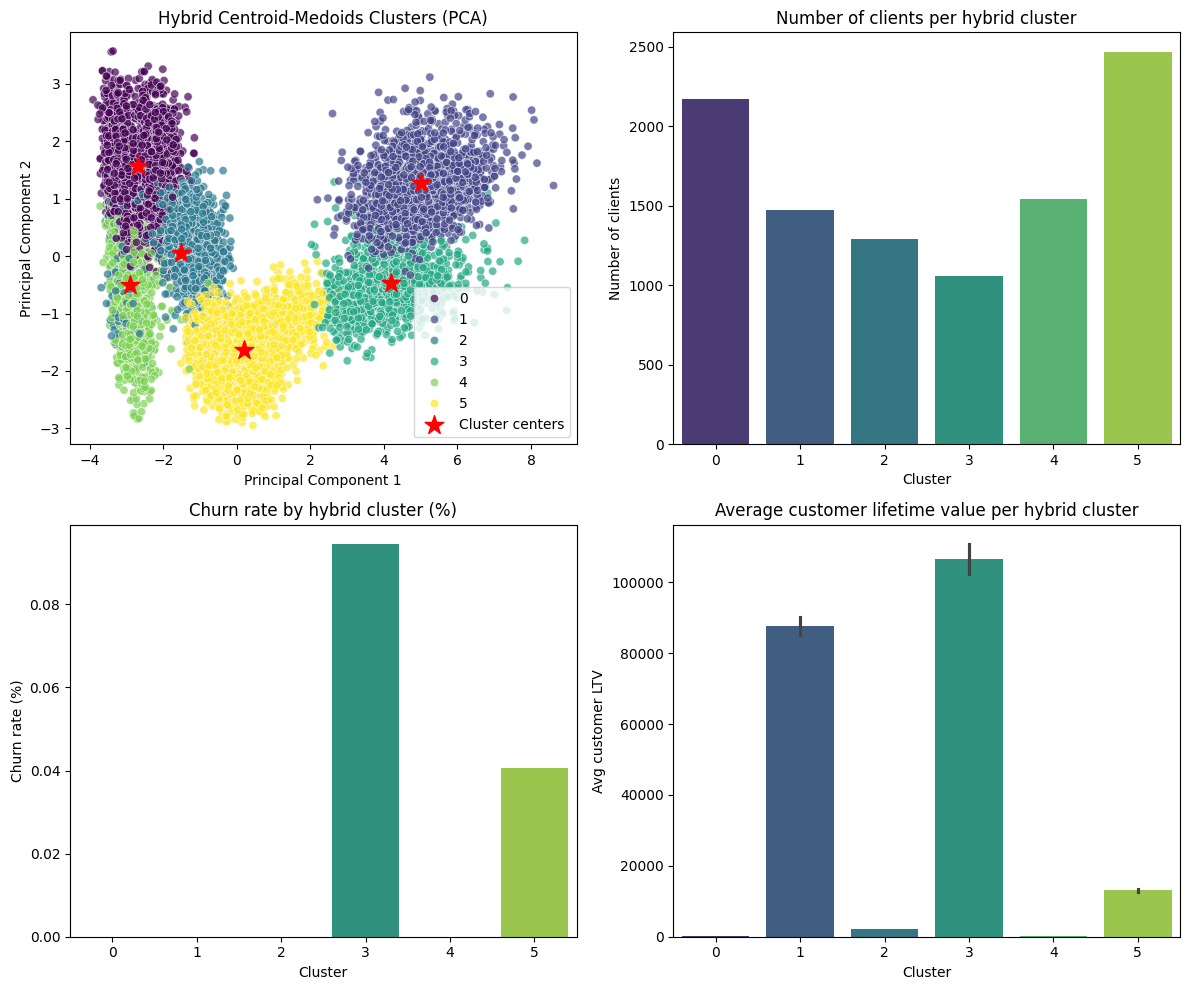

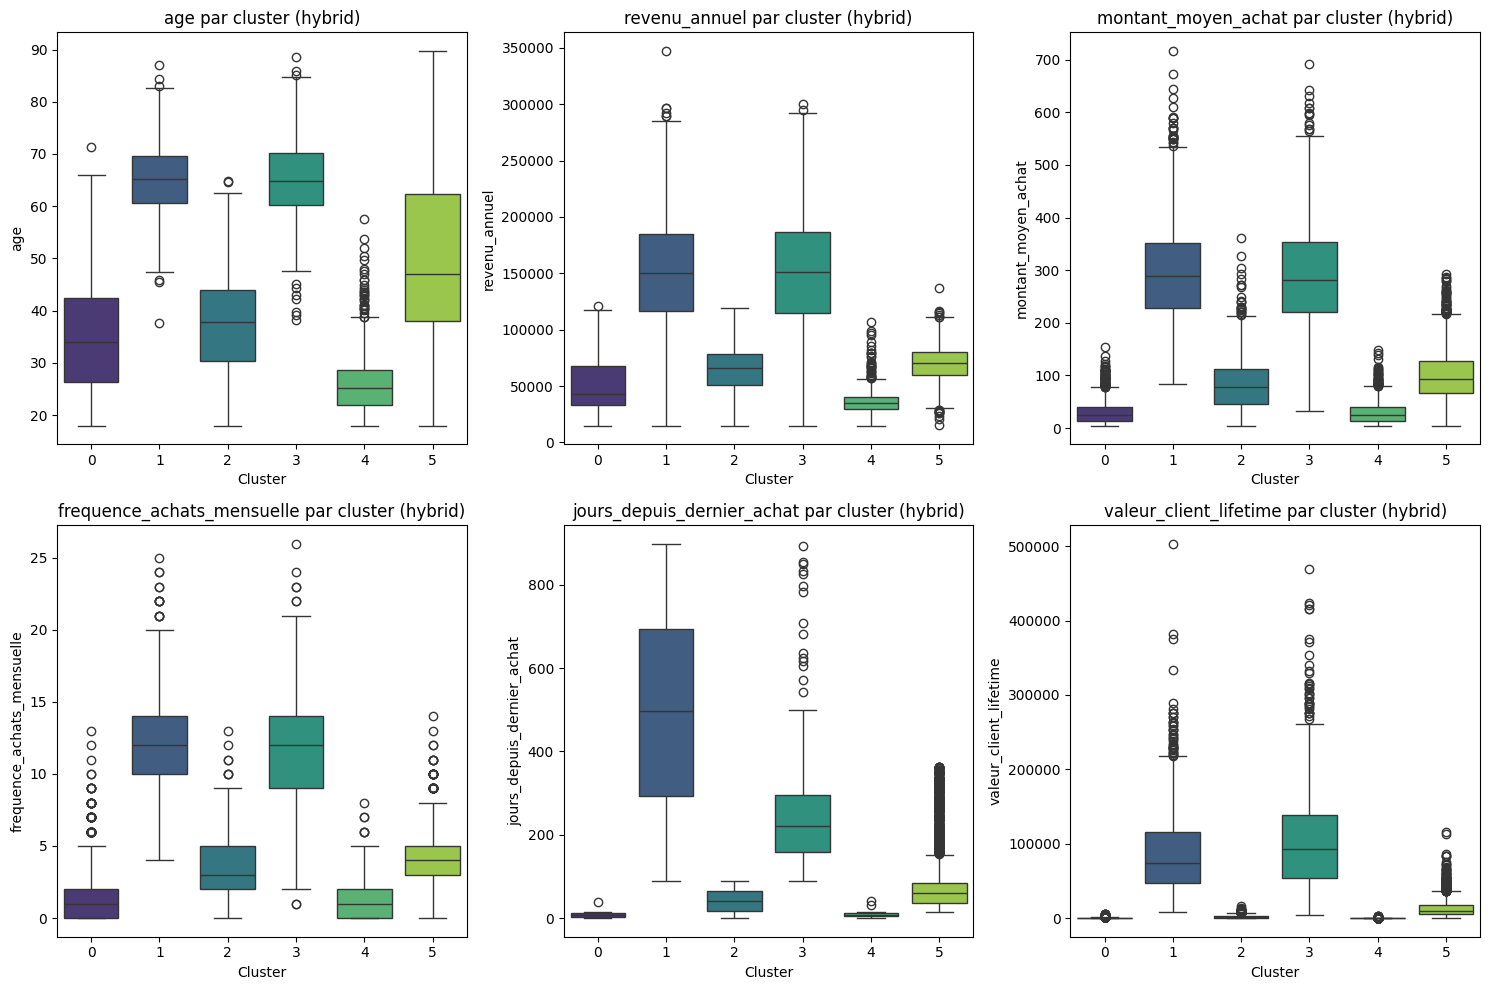

In [19]:
# ——— Préparation du dataframe pour la méthode hybride ———
df_hybrid = df.copy()
df_hybrid['cluster_hybrid'] = labels_kmm  # labels issus de centroid_medoids

# 1) Profil moyen par cluster
hybrid_cluster_stats = df_hybrid.groupby('cluster_hybrid')[features].mean()
print("\nAverage profile of hybrid clusters:")
print(hybrid_cluster_stats)

# 2) Distribution des clients par cluster
hybrid_cluster_counts = df_hybrid['cluster_hybrid'].value_counts().sort_index()
print("\nDistribution of clients by hybrid cluster:")
print(hybrid_cluster_counts)

# 3) Taux de churn par cluster
hybrid_churn_by_cluster = df_hybrid.groupby('cluster_hybrid')['churn'].mean() * 100
print("\nChurn rate by hybrid cluster (%):")
print(hybrid_churn_by_cluster)

# ——— Visualisation des clusters hybrides ———
#  Projection PCA (reuse de la même PCA que pour K-means/K-medoids)
X_pca_hybrid = pca.transform(X_processed)

plt.figure(figsize=(12, 10))

# A) Scatter plot des clusters
plt.subplot(2, 2, 1)
sns.scatterplot(
    x=X_pca_hybrid[:, 0],
    y=X_pca_hybrid[:, 1],
    hue=labels_kmm,
    palette='viridis',
    alpha=0.7,
    legend='full'
)
plt.title('Hybrid Centroid‑Medoids Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# B) Centres de clusters (centroïdes / medoids initiaux)
centers = model_kmm.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    s=200,
    marker='*',
    c='red',
    label='Cluster centers'
)
plt.legend()

# C) Distribution des clients par cluster
plt.subplot(2, 2, 2)
sns.countplot(
    x='cluster_hybrid',
    data=df_hybrid,
    palette='viridis'
)
plt.title('Number of clients per hybrid cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of clients')

# D) Taux de churn par cluster
plt.subplot(2, 2, 3)
sns.barplot(
    x=hybrid_churn_by_cluster.index,
    y=hybrid_churn_by_cluster.values,
    palette='viridis'
)
plt.title('Churn rate by hybrid cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Churn rate (%)')

# E) Valeur client moyenne par cluster
plt.subplot(2, 2, 4)
sns.barplot(
    x='cluster_hybrid',
    y='valeur_client_lifetime',
    data=df_hybrid,
    palette='viridis'
)
plt.title('Average customer lifetime value per hybrid cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg customer LTV')

plt.tight_layout()
plt.show()

# ——— Analyse détaillée des caractéristiques par cluster ———
plt.figure(figsize=(15, 10))
features_to_plot = [
    'age', 'revenu_annuel', 'montant_moyen_achat',
    'frequence_achats_mensuelle', 'jours_depuis_dernier_achat',
    'valeur_client_lifetime'
]

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        x='cluster_hybrid',
        y=feature,
        data=df_hybrid,
        palette='viridis'
    )
    plt.title(f'{feature} par cluster (hybrid)')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()
